<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/3%20Aprendizaje%20profundo%20(II)/VAEmos_a_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
from PIL import Image

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output

from sklearn.model_selection import train_test_split

class EncoderV(tf.keras.layers.Layer): #Heredamos de la clase Layer porque vamos a crear un conjunto de capas
    def __init__(self, latent_dim = 2, layers = [128, 64, 32]):
        super(EncoderV, self).__init__()

        #self.entrada = tf.keras.layers.Input(shape=(784,))
        self.encoder = [tf.keras.layers.Conv2D(filters, 3, strides = 2, activation = "relu", padding = "same") for filters in layers]
        self.flatten = tf.keras.layers.Flatten()
        
        #Se bifurca para sacar la mu y la log_var
        #Activaciones lineales porque no queremos shenanigans
        self.mu = tf.keras.layers.Dense(latent_dim, activation = "linear")
        self.log_var = tf.keras.layers.Dense(latent_dim, activation = "linear")
    
    def call(self, inputs, training = None, mask = None):
        #y = self.entrada(inputs)
        y = inputs
        for layer in self.encoder:
            y = layer(y)
        y = self.flatten(y)
        #Se bifurca para sacar la mu y la log_var
        mu = self.mu(y)
        log_var = self.log_var(y)

        return mu, log_var

class Resampling(tf.keras.layers.Layer):
    def __init__(self):
        super(Resampling, self).__init__()

    def call(self, inputs, training = None, mask = None):
        mu, log_var = inputs
        epsilon = tf.random.normal(shape = tf.shape(mu), mean = 0., stddev=1.)
        
        return mu + tf.exp(log_var / 2) * epsilon

class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_size = 784, layers = [128, 64, 32]):
        super(Decoder, self).__init__()

        #Replicamos la estructura del Encoder pero en orden inverso
        self.decoder = [tf.keras.layers.Conv2DTranspose(filters, 3, strides = 2, activation = "relu", padding = "same") for filters in reversed(layers)]

        #Hay que replicar el flatten del encoder
        self.deflatten = tf.keras.layers.Dense(8 * 8 * layers[1], activation = "relu")
        #Añadimos la capa final
        self.decoder.append(tf.keras.layers.Conv2DTranspose(1, 3, strides = 1, activation = "relu", padding = "same"))

    def call(self, inputs, training = None, mask = None):
        y = inputs
        y = self.deflatten(y)
        y = tf.keras.layers.Reshape((8,8,64))(y)
        for layer in self.decoder:
            y = layer(y)

        return y

class BetaVariationalAutoEncoderConv(tf.keras.Model):
    def __init__(self, input_size = 784, latent_dim = 2, layers = [128, 64, 32], beta = 1, use_gamma = False):
        super(BetaVariationalAutoEncoderConv, self).__init__()

        self.encoder = EncoderV(latent_dim, layers)
        self.resampling = Resampling()
        self.decoder = Decoder(input_size, layers)
        self.mu = 0
        self.log_var = 0
        self.beta = beta
        self.input_size = input_size
        self.latent_dim = latent_dim
        self.gamma = tf.Variable(1 / 2 ** (1/2), trainable=False)
        self.use_gamma = use_gamma
        self.k = (2*self.input_size**(1/2)/self.latent_dim)**2
        
    def vae_kl_loss(self):
        kl_loss = -0.5 * tf.reduce_mean(1 + self.log_var - tf.square(self.mu) - tf.exp(self.log_var))
        return kl_loss

    def gen_loss(self, mse, gamma, kl):
        return mse / (2*gamma ** 2) + kl
        
    #Not very efficient but working
    def generate(self, N = 1):
        predictions = []
        for i in range(N):    
            sample = tf.random.normal(mean = 0, stddev = 1, shape = (2,self.latent_dim))
            predictions.append(self.decoder(tf.expand_dims(self.resampling(sample), axis = 0)).numpy())
        predictions = np.array(predictions)
        return predictions.reshape(-1, self.input_size)

    def call(self, inputs, training = None, mask = None):
        mu, log_var = self.encoder(inputs)
        self.mu, self.log_var = mu,log_var
        z = self.resampling((mu, log_var)) 
        decoded = self.decoder(z)
        self.add_loss(self.vae_kl_loss())
        return decoded

    def train_step(self, data):
        X_train, Y_train = data

        if self.use_gamma:
            with tf.GradientTape() as tape:
                reconstructed = self(X_train)
                
                mse = tf.keras.losses.MeanSquaredError()(reconstructed, X_train)
                gl = mse / (2 * self.gamma ** 2) + tf.math.log(self.gamma) + 0.91893
                kl = sum(self.losses)
                # total = self.input_size * tf.cast(mse, "float32") + self.beta * self.latent_dim * kl
                # total = self.input_size * tf.cast(mse, "float32") / (2*self.gamma**2) + self.beta * self.latent_dim * kl
                total = gl + kl * self.k
        else:
            with tf.GradientTape() as tape:
                reconstructed = self(X_train)

                mse = tf.keras.losses.MeanSquaredError()(reconstructed, X_train)
                kl = sum(self.losses)
                total = tf.cast(mse, "float32") + kl * self.k
                gl = 0
        
        gradients = tape.gradient(total, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.gamma.assign(tf.minimum(self.gamma, mse))
        # return {"MSE": self.input_size * mse , "KL": self.beta * self.latent_dim * kl, "Total": total, "Gamma" : self.gamma}    
        return {"MSE": mse , "KL": kl * self.k, "GL": gl, "Total": total, "Gamma" : self.gamma}   

# Dataset

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
directory2 = "gdrive/MyDrive/UNIVERSIDAD/Master Propio IA UV/3 Aprendizaje profundo (II)/Trabajo final/fonts2"

In [5]:
# get data file names (this code takes a while to retrieve all data and prepare all fonts)
images_total = 1200

filenames = glob.glob(directory2 + "/*.png")
images = list()
for i in range(images_total):
  images.append(np.array(Image.open(filenames[i])))
  if i % 25 == 0:
    print(i+1, '/', images_total)
#images = [np.array(Image.open(filenames[i])) for i in range(len(filenames)) if i < images_total]

1 / 1200
26 / 1200
51 / 1200
76 / 1200
101 / 1200
126 / 1200
151 / 1200
176 / 1200
201 / 1200
226 / 1200
251 / 1200
276 / 1200
301 / 1200
326 / 1200
351 / 1200
376 / 1200
401 / 1200
426 / 1200
451 / 1200
476 / 1200
501 / 1200
526 / 1200
551 / 1200
576 / 1200
601 / 1200
626 / 1200
651 / 1200
676 / 1200
701 / 1200
726 / 1200
751 / 1200
776 / 1200
801 / 1200
826 / 1200
851 / 1200
876 / 1200
901 / 1200
926 / 1200
951 / 1200
976 / 1200
1001 / 1200
1026 / 1200
1051 / 1200
1076 / 1200
1101 / 1200
1126 / 1200
1151 / 1200
1176 / 1200


In [99]:
CATEGORIES = 26

In [103]:
# each image is just letters A-Z from the same font concatenated in 1664x64 format: each letter is 64x64
# we need to split the data into individual pictures for each letter
letter_size = 64
letter_amount = 26
using_amount = CATEGORIES

letters = np.zeros(shape=(using_amount*len(images), letter_size, letter_size, 1))
letters_label = np.zeros(shape=(using_amount*len(images), using_amount))
for i in range(len(images)):
  #images[i] = images[i]
  j = 0
  #k = 8
  for j in range(using_amount):
    letters[i*using_amount + j, :, :, 0] = (255 - images[i][:, j*letter_size : (j+1)*letter_size])/255 #we will only use one of the channels
    letters_label[i*using_amount + j] = j
letters_label = letters_label.astype(np.int32)

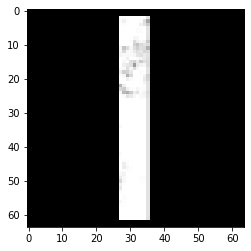

In [58]:
plt.imshow(X_train[187][:,:,0], cmap='gray')

In [64]:
X_train[0][:,:,0]

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]])

In [104]:
X_train, X_test, Y_train, Y_test = train_test_split(letters, letters_label, shuffle=True, stratify=letters_label, test_size=0.25)

In [101]:
BATCH_SIZE = 32
EPOCHS = 50

In [105]:
model = BetaVariationalAutoEncoderConv(input_size=64, latent_dim=50, beta=1, use_gamma=True)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = model.fit(x=X_train, y=X_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(X_test, X_test), shuffle=True)

Epoch 1/50
732/732 [==============================] - 22s 30ms/step - MSE: 0.0393 - KL: 0.3749 - GL: 26.7117 - Total: 27.0866 - Gamma: 0.0337 - val_loss: 4.7951 - val_mse: 0.0195
Epoch 2/50
732/732 [==============================] - 21s 28ms/step - MSE: 0.0167 - KL: 0.5194 - GL: 74.4213 - Total: 74.9408 - Gamma: 0.0105 - val_loss: 5.3048 - val_mse: 0.0149
Epoch 3/50
732/732 [==============================] - 21s 29ms/step - MSE: 0.0135 - KL: 0.5495 - GL: 88.0829 - Total: 88.6324 - Gamma: 0.0086 - val_loss: 5.3920 - val_mse: 0.0146
Epoch 4/50
732/732 [==============================] - 21s 29ms/step - MSE: 0.0124 - KL: 0.5666 - GL: 111.3499 - Total: 111.9165 - Gamma: 0.0073 - val_loss: 5.5856 - val_mse: 0.0125
Epoch 5/50
732/732 [==============================] - 21s 28ms/step - MSE: 0.0116 - KL: 0.5792 - GL: 130.1043 - Total: 130.6835 - Gamma: 0.0066 - val_loss: 5.6909 - val_mse: 0.0122
Epoch 6/50
732/732 [==============================] - 21s 28ms/step - MSE: 0.0113 - KL: 0.6012 - GL: 

KeyboardInterrupt: ignored

In [92]:
lil.shape

(320, 64)

In [95]:
lil = model.generate(1)

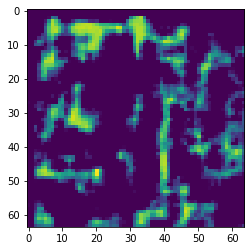

In [96]:
plt.imshow(lil)

In [ ]:
lel = model.predict(X_test)

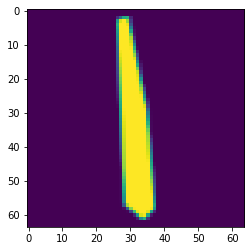

In [84]:
plt.imshow(X_test[30][:,:,0])

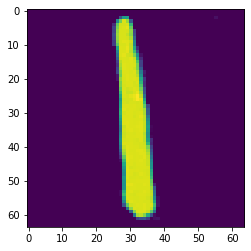

In [85]:
plt.imshow(lel[30][:,:,0])

In [63]:
lol = model.predict(X_train)

In [66]:
lol[:][:,:,0].sum().sum().sum()

0.0